In [3]:
#imports 

%tensorflow_version 2.x
import tensorflow as tf 
from tensorflow import keras 

#Help-liberies 
import numpy as np
import matplotlib.pyplot as plt

In [4]:
#The function takes the train labels and the amount of noise we want to apply 
#The return value is the train_labels with noise 
import random

def adding_noise(labels, percent):
  labels_with_noise = np.zeros((len(labels)))
  for i in range(len(labels)):
    r = random.random()
    if r < percent:
      labels_with_noise[i] = int(labels[i] + 1+ 9*random.random())%10
    else:
      labels_with_noise[i] = labels[i] 
  return labels_with_noise

Creating the Class Model, where modelscan be created, trained and observed


In [25]:


class Model:
      model = keras.Sequential()

      def __init__(self, layers, layersize):

        self.layers = layers
        self.layersize = layersize
        #initializing the model
        self.model = keras.Sequential()
        self.model.add(keras.layers.Flatten(input_shape=(28,28)))#input layer
        for j in range(0, layers):
          self.model.add(keras.layers.Dense(layersize, activation="relu",
                                            kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1),bias_constraint=tf.keras.constraints.MinMaxNorm(
min_value=0.0, max_value=0.0, rate=1.0, axis=0))) #hidden layers
        self.model.add(keras.layers.Dense(10,activation='softmax',kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.1))) #output layer
        #compile model
        self.model.compile(optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.1),loss= 'sparse_categorical_crossentropy',metrics=['accuracy'])  
        self.model.count_params()

      '''
      trains the model and returns a List of various data
      data[0] = the train loss after fitting the data 
      data[1] = the train accuracy after fitting the data  
      data[2] = the test loss after evaluating the model 
      data[3] = the test accuracy after evaluating the model  
      '''

      def train(self,epoch,datasize,train_images,train_labels,test_images, test_labels):
        data = np.zeros(5)
        print(datasize,epoch)

        #trainig the model until a certain accuracy is reached
        runs = 0
        train_loss = 100
        train_acc = 0
        e_per_run = 1
        while (train_loss > 0.01) and runs < epoch:
          history = self.model.fit(train_images[:datasize], train_labels[:datasize],epochs = e_per_run)
          train_loss_all, train_acc_all = history.history.values()
          train_loss = train_loss_all[e_per_run-1]
          train_acc = train_acc_all[e_per_run-1]
          runs = runs + e_per_run

        test_loss, test_acc = self.model.evaluate(test_images, test_labels, verbose=1)
        data[0] = train_loss
        data[1] = train_acc
        data[2] = test_loss
        data[3] = test_acc
        data[4] = runs
        print(self.model.summary())
        return data

      def getParameter(self):
        return self.model.count_params()



In [2]:




def trainModel(amount,min_layersize,max_layersize, layers, epochs, datasize, noise):
  a = max_layersize - min_layersize 
  data = np.zeros((8,a))

  #load dataset MNIST
  mnist = keras.datasets.mnist
  #spliting into testing and training
  (train_images, train_labels_without_noise), (test_images, test_labels) = mnist.load_data()
  #normalizing data
  train_images = train_images/255.0
  test_images = test_images/255.0
  #adding noise
  train_labels = adding_noise(train_labels_without_noise, noise)

  
  '''
  data[0][i] = the train loss after fitting the data in iterration i (with i layers) 
  data[1][i] = the train accuracy after fitting the data in iterration i (with i layers)  
  data[2][i] = the test loss after evaluating the model in iterration i (with i layers) 
  data[3][i] = the test accuracy after evaluating the model in iterration i (with i layers) 
  data[4][i] = epochs needed for reachen train-risk < 0.01 in iterration i (with i layers)
  data[5][i] = average weight change in itteration i (with i layers)
  data[6][i] = average bias change in itteration i (with i layers)
  '''

  for i in range(0,max_layersize - min_layersize):
    data_help = np.zeros(8)
    for j in range(0,amount):
      print("I an currently in run ",i, " ===> The model has ", i+ min_layersize ,"neurons. ")
      print("amount =", amount) 
      myModel = Model(layers,i + min_layersize)

      #getting the weight-Vectors
      layer_weights_bevor = myModel.model.layers[1].get_weights()[0]
      layer_biases_bevor  = myModel.model.layers[1].get_weights()[1]

      history = myModel.train(epochs, datasize,train_images,train_labels,test_images, test_labels)
      param   = myModel.getParameter()

      #getting the weight-Vectors
      layer_weights = myModel.model.layers[1].get_weights()[0]
      layer_biases  = myModel.model.layers[1].get_weights()[1]
      
      
      #weight change
      print("Weightchange: " ,np.shape(abs(layer_weights_bevor) - abs(layer_weights)))
      change_weights = abs((layer_weights_bevor) - (layer_weights)).flatten() 
      change_biases = abs((layer_biases_bevor) - (layer_biases)).flatten()

      average_weights_change = sum(change_weights)/len(change_weights)
      average_biases_change = sum(change_biases)/len(change_biases)
      print(average_weights_change)




      data_help[0] = data_help[0] + history[0] 
      data_help[1] = data_help[1] + history[1]
      data_help[2] = data_help[2] + history[2]
      data_help[3] = data_help[3] + history[3]
      data_help[4] = data_help[4] + history[4]
      data_help[5] = data_help[5] + average_weights_change
      data_help[6] = data_help[6] + average_biases_change
      

    #maby filtering runs, that went wrong
    data[0][i] = data_help[0]/amount
    data[1][i] = data_help[1]/amount
    data[2][i] = data_help[2]/amount
    data[3][i] = data_help[3]/amount
    data[4][i] = data_help[4]/amount
    data[5][i] = data_help[5]/amount
    data[6][i] = data_help[6]/amount
  return data 

in the next block, i want to creata a example curve of the double descent

In [ ]:

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm

def plot__epochs_needed(max_epochs):
  min_layer = 1
  max_layer = 80
  data = trainModel(1,min_layer,max_layer,1, max_epochs ,4000, 0.15) 
  data_epochs = data[4]
  colors = ['red' if x == max_epochs else 'blue' for x in data_epochs]
  

  fig, [ax1,ax2] = plt.subplots(2)

  par1 = ax1.twinx()
  par2 = ax2.twinx()

  fig.set_size_inches(20,30)
  ax1.bar(np.linspace(min_layer,(max_layer-1),(max_layer) - (min_layer)), data_epochs, color = colors , width = 0.8)
  ax1.set_xlabel('Layersize')
  ax1.set_ylabel('Amount of epochs needed')
  par1.plot(np.linspace(min_layer,(max_layer-1),(max_layer) - (min_layer)),data[2], color = 'black', label = 'test loss', linewidth= 4.0)
  par1.set_ylabel('train loss')

  ax2.bar(np.linspace(min_layer,(max_layer-1),(max_layer) - (min_layer)), data[5], color = colors , width = 0.8)
  ax2.set_xlabel('Layersize')
  ax2.set_ylabel('Average weight-change')
  par2.plot(np.linspace(min_layer,(max_layer-1),(max_layer) - (min_layer)),data[2], color = 'black', label = 'test loss', linewidth= 4.0)
  par2.set_ylabel('train loss')


  #legend
  import matplotlib.patches as mpatches

  pop_a = mpatches.Patch(color='red', label="0 test-loss not reached after " + str(max_epochs) + " epochs")
  pop_b = mpatches.Patch(color='blue', label="0 test-loss reached after " + str(max_epochs) + " epochs")

  ax1.legend(handles=[pop_a,pop_b])
  ax2.legend(handles=[pop_a,pop_b])
   
  plt.savefig("kurve_with_various_epochs.png")


plot__epochs_needed(200)


NameError: ignored

We now want to estemate the desity-functions of the change of the weights
We observed a decreasing average weightchange over time. It would be nice to observe, that the network does not change some weights at all. 

In [21]:
def trainModel_for_density(amount,layersizes, layers, epochs, datasize, noise):
  a = len(layersizes)
  data = np.zeros((7,a))
  w_b = []
  w_a = []
  w_c = []
 

  #load dataset MNIST
  mnist = keras.datasets.mnist
  #spliting into testing and training
  (train_images, train_labels_without_noise), (test_images, test_labels) = mnist.load_data()
  #normalizing data
  train_images = train_images/255.0
  test_images = test_images/255.0
  #adding noise
  train_labels = adding_noise(train_labels_without_noise, noise)

  
  '''
  data[0][i] = x-axes of the density function
  data[1][i] = density function
  data[2][i] = the test loss after evaluating the model in iterration i (with i layers) 
  data[3][i] = the test accuracy after evaluating the model in iterration i (with i layers) 
  data[4][i] = epochs needed for reachen train-risk < 0.01 in iterration i (with i layers)
  data[5][i] = average weight change in itteration i (with i layers)
  data[6][i] = average bias change in itteration i (with i layers)
  '''

  for i in range(len(layersizes)):
    data_help = np.zeros(7)
    
   
    print("I an currently with " + str(layersizes[i]) + "neurons ")

    #creating Model
    myModel = Model(layers,layersizes[i])

    #getting the weight-Vectors
    layer_weights_bevor = myModel.model.layers[2].get_weights()[0]
    layer_biases_bevor  = myModel.model.layers[1].get_weights()[1]

    history = myModel.train(epochs, datasize,train_images,train_labels,test_images, test_labels)
    param   = myModel.getParameter()

    #getting the weight-Vectors
    layer_weights = myModel.model.layers[2].get_weights()[0]
    layer_biases  = myModel.model.layers[1].get_weights()[1]

    #weight change
    change_weights = abs((layer_weights_bevor) - (layer_weights)).flatten() 
    change_biases = abs((layer_biases_bevor) - (layer_biases)).flatten()

    average_weights_change = sum(change_weights)/len(change_weights)
    average_biases_change = sum(change_biases)/len(change_biases)

    w_b.append(layer_weights_bevor)
    w_a.append(layer_weights)
    w_c.append(change_weights)


    data[0][i] = history[0] 
    data[1][i] = history[1]
    data[2][i] = history[2]
    data[3][i] = history[3]
    data[4][i] = history[4]
    data[5][i] = average_weights_change
    data[6][i] = average_biases_change
  return [w_c,w_b,w_a,data]

I an currently with 11neurons 
15000 300
313/313 [==============================] - 1s 2ms/step - loss: 0.7389 - accuracy: 0.9074
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_37 (Flatten)        (None, 784)               0         
                                                                 
 dense_74 (Dense)            (None, 11)                8635      
                                                                 
 dense_75 (Dense)            (None, 10)                120       
                                                                 
Total params: 8,755
Trainable params: 8,755
Non-trainable params: 0
_________________________________________________________________
None
I an currently with 20neurons 
15000 300
313/313 [==============================] - 1s 2ms/step - loss: 0.2785 - accuracy: 0.9421
Model: "sequential_40"
___________________________

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

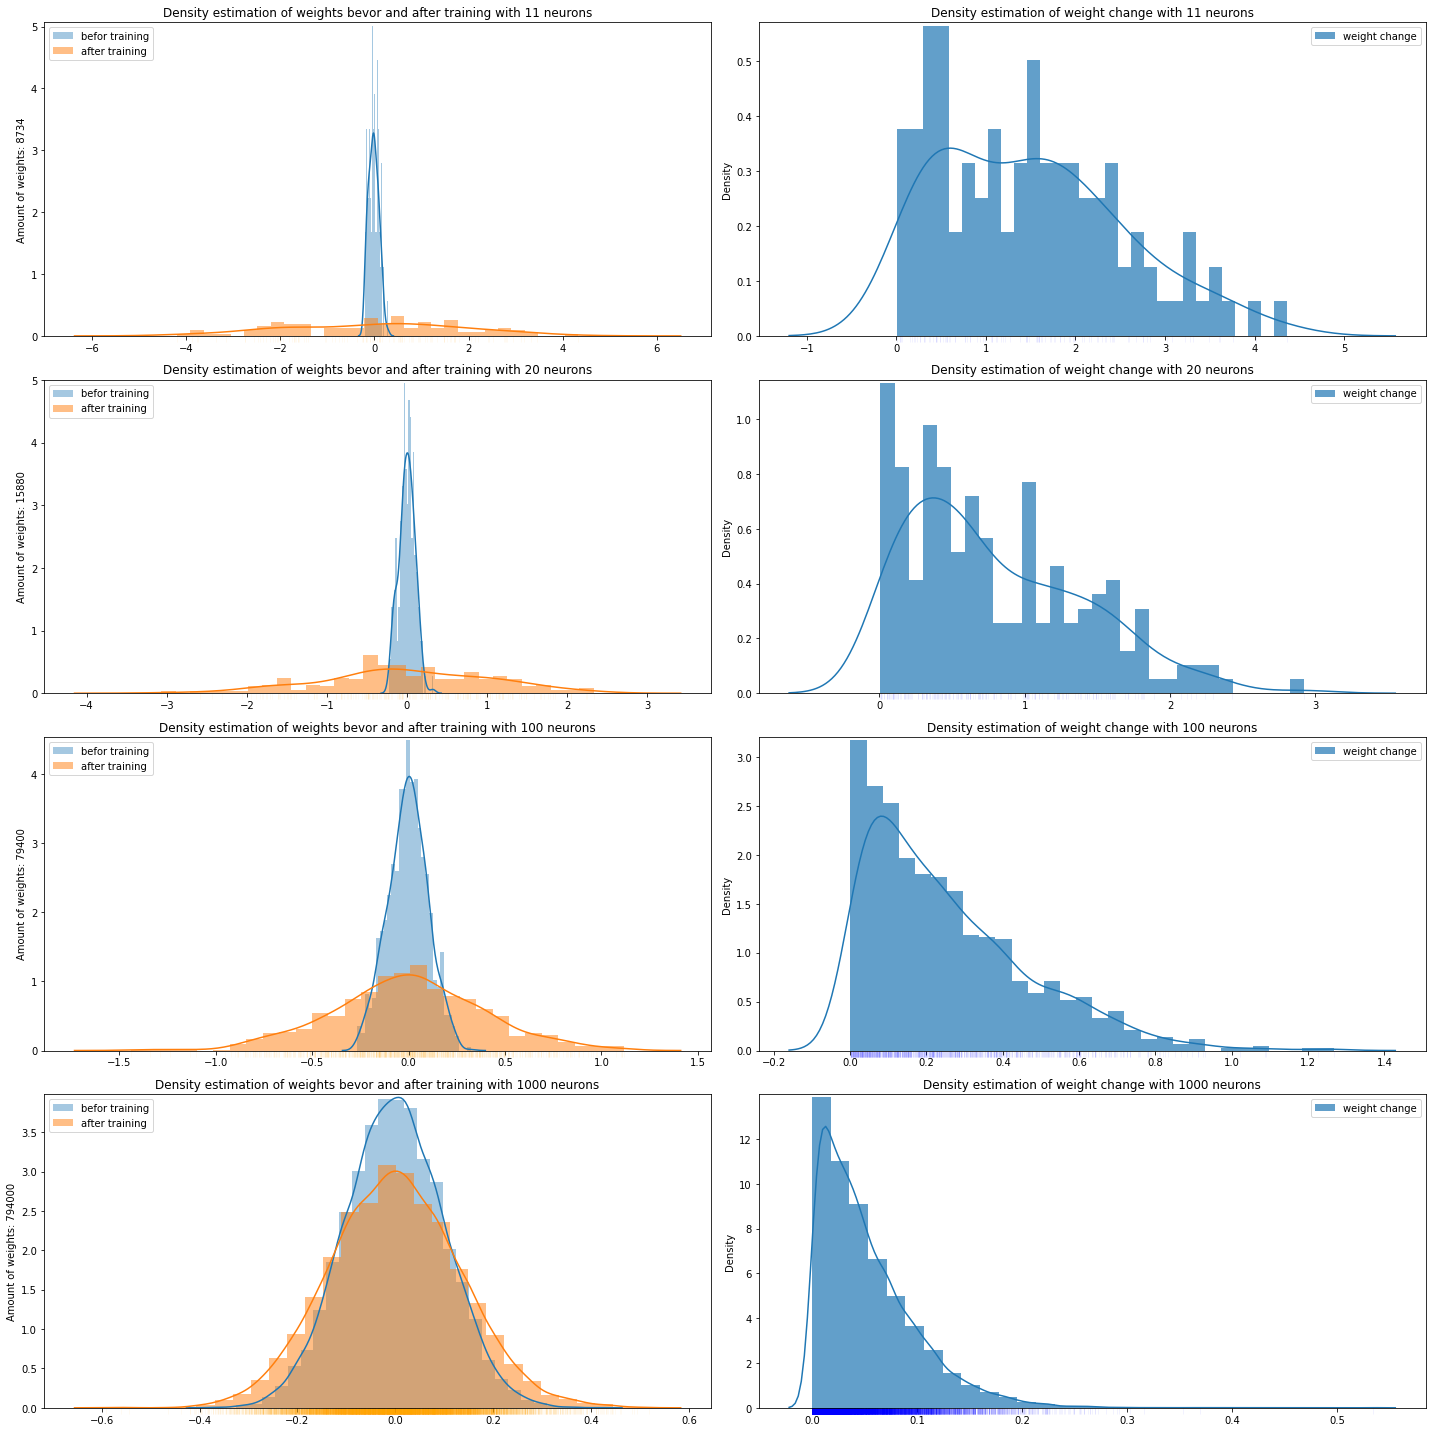

In [26]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import matplotlib.patches as mpatches
from sklearn.utils.fixes import parse_version
import matplotlib
import seaborn as sns


def plot_weightchange_density(layersizes):

  max_epochs = 300
  w_change,lw_b,lw_a,data = trainModel_for_density(1,layersizes,1, max_epochs ,15000, 0) 
  
  fig, ax = plt.subplots(len(layersizes),2)
  fig.set_size_inches(20,20)

  for i in range(len(layersizes)):
    ax[i][0].set_title("Density estimation of weights bevor and after training with " + str(layersizes[i]) + " neurons")
    ax[i][0].set_ylabel("Amount of weights: " + str((784)*layersizes[i] + 10*layersizes[i]))
    sns.distplot(lw_b[i].flatten(), ax = ax[i][0],bins = 30, label="befor training" )
    sns.distplot(lw_a[i].flatten(), ax = ax[i][0],bins = 30, label="after training" , hist_kws=dict(alpha=0.5))
    sns.rugplot(data=lw_a[i].flatten(), height=-.02, clip_on=False, ax = ax[i][0], color = "orange" , alpha = 0.05 )


    
    ax[i][1].set_title("Density estimation of weight change with " + str(layersizes[i]) + " neurons")
    sns.distplot(w_change[i].flatten(), ax = ax[i][1],bins = 30, label = "weight change", hist_kws=dict(alpha=0.7))
    sns.rugplot(data= w_change[i].flatten(), height=-.02, clip_on=False, ax = ax[i][1],color = "blue" , alpha = 0.05 )



    #legend
    ax[i][0].legend(loc = "upper left")
    ax[i][1].legend(loc = "upper right")


  
  fig.set_facecolor('w')
  plt.tight_layout()
  plt.show()


plot_weightchange_density([11,20,100,1000])

LDA


I an currently with 11neurons 
15000 300
313/313 [==============================] - 1s 2ms/step - loss: 0.7712 - accuracy: 0.9115
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 784)               0         
                                                                 
 dense_46 (Dense)            (None, 11)                8635      
                                                                 
 dense_47 (Dense)            (None, 10)                120       
                                                                 
Total params: 8,755
Trainable params: 8,755
Non-trainable params: 0
_________________________________________________________________
None
I an currently with 1000neurons 
15000 300
313/313 [==============================] - 2s 6ms/step - loss: 0.1183 - accuracy: 0.9653
Model: "sequential_25"
_________________________

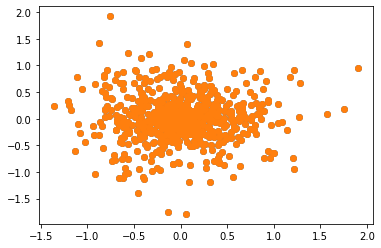